In [1]:
import os
import sys
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from pathlib import Path

unflex_wc = ""
flex_wc = "int-tank-ss-v2g"

In [2]:
coarse_regions = {
    "Scotland": ["GB0 Z1_1", "GB0 Z1_1", "GB0 Z1_3", "GB0 Z1_2", "GB0 Z1_4", "GB0 Z2", "GB0 Z3", "GB0 Z4", "GB0 Z5"],
    "Cornwall": ["GB0 Z17"],
    "Wales, West-England": ["GB0 Z13", "GB0 Z9"],
    "South-East England": ["GB0 Z16", "GB0 Z15", "GB0 Z14", "GB0 Z12"],
    "North-East England": ["GB0 Z11", "GB0 Z10", "GB0 Z8", "GB0 Z7", "GB0 Z6"],
    # "Scotland, North England": ["GB0 Z1_1", "GB0 Z1_1", "GB0 Z1_3", "GB0 Z1_2", "GB0 Z1_4", "GB0 Z2", "GB0 Z3", "GB0 Z4", "GB0 Z5", "GB0 Z7", "GB0 Z6"],
    # "Cornwall": ["GB0 Z17"],
    # "Wales, West-England": ["GB0 Z13", "GB0 Z9"],
    # "South-East England": ["GB0 Z16", "GB0 Z15", "GB0 Z14", "GB0 Z12"],
    # "East England": ["GB0 Z11", "GB0 Z10", "GB0 Z8"],
}
reverse_coarse_regions = {v: k for k, vs in coarse_regions.items() for v in vs}

In [3]:
base = Path.cwd().parent / "results" / "pypsa-fes" / "networks"
template = "elec_s_ec_lhnd__{}_LW_{}.nc"

years = [2025, 2030, 2035, 2040, 2045, 2050]

regions = gpd.read_file(Path.cwd().parent / "resources" / "pypsa-fes" / "regions_onshore_elec_s_eso.geojson")
regions.index = regions["name"]
regions = regions.loc[regions.index.str.contains("GB")]
regions.loc[:,["coarse_regions"]] = regions["name"].apply(lambda x: reverse_coarse_regions[x])

In [4]:
idx = pd.IndexSlice

flex_data = pd.DataFrame(0, index=years, columns=coarse_regions.keys()).stack()
none_data = pd.DataFrame(0, index=years, columns=coarse_regions.keys()).stack()

flex_data = pd.DataFrame(0, index=flex_data.index, columns=["solar", "wind"])
none_data = pd.DataFrame(0, index=none_data.index, columns=["solar", "wind"])


for year in years:
    
    flex = pypsa.Network(base / template.format(flex_wc, year))
    none = pypsa.Network(base / template.format(unflex_wc, year))

    def get_carrier(n, carrier):

        if carrier == "wind" or carrier == "solar":
            solar = (g := n.generators).loc[g.carrier.str.contains(carrier)]
        else:
            solar = (g := n.generators).loc[g.carrier == carrier]

        solar.loc[:, ["bus"]] = solar.bus.str.split(" ").str[:2].str.join(" ")
        solar.loc[solar.bus.str.contains("GB"), ].groupby("bus")["p_nom_opt"].sum()

        result = pd.Series(index=coarse_regions.keys())
        for region, buses in coarse_regions.items():
            result[region] = solar.loc[solar.bus.isin(buses), "p_nom_opt"].sum()
        
        return result
    
    flex_data.loc[idx[year, :], ["solar"]] = get_carrier(flex, "solar").values
    flex_data.loc[idx[year, :], ["wind"]] = get_carrier(flex, "wind").values

    none_data.loc[idx[year, :], ["solar"]] = get_carrier(none, "solar").values
    none_data.loc[idx[year, :], ["wind"]] = get_carrier(none, "wind").values


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported ne

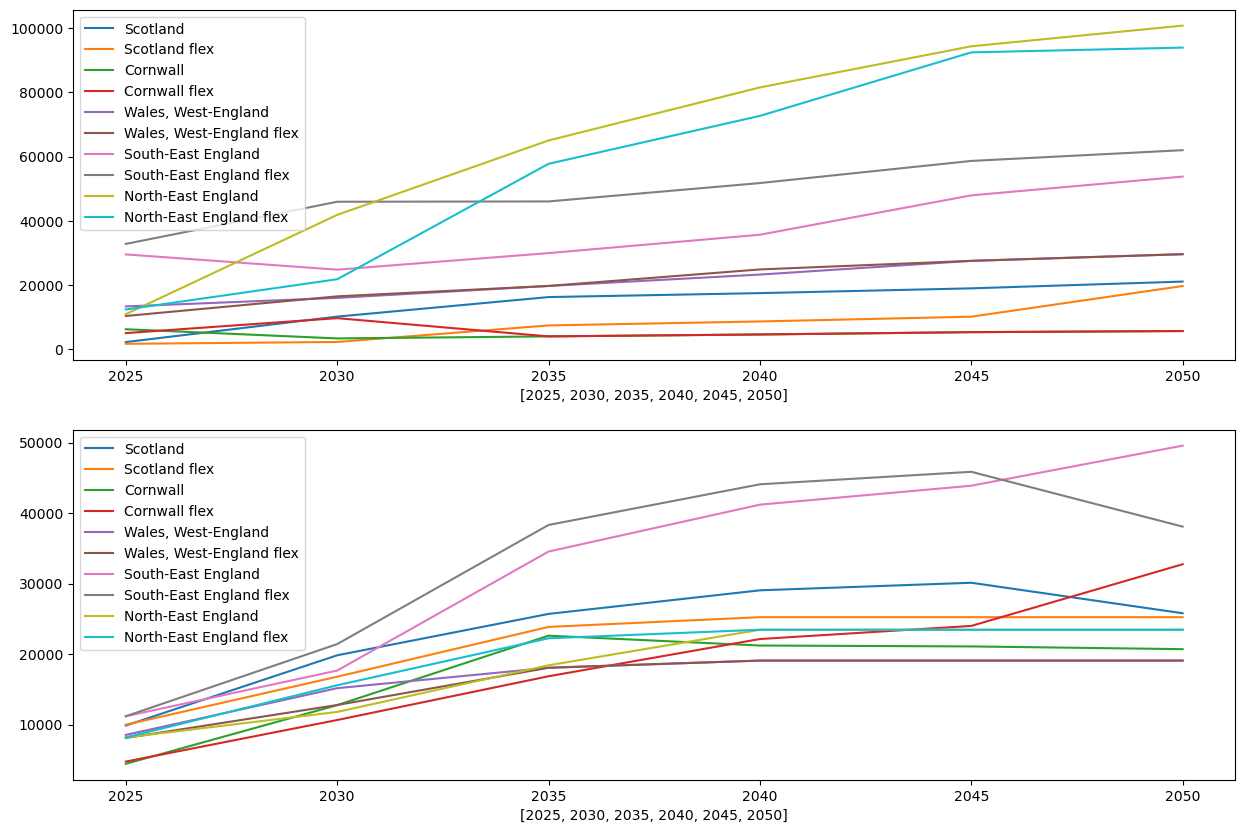

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# print(none_data.loc[idx[:, ["Scotland"]]])

for region in coarse_regions.keys():
    axs[0].plot(years, none_data.loc[idx[:, [region]], "solar"].values, label=region)
    axs[1].plot(years, none_data.loc[idx[:, [region]], "wind"].values, label=region)
    axs[0].plot(years, flex_data.loc[idx[:, [region]], "solar"].values, label=region + " flex")
    axs[1].plot(years, flex_data.loc[idx[:, [region]], "wind"].values, label=region + " flex")

    # axs[0, 1].plot(years, none_data.loc[idx[:, [region]].wind.values, label=region)
    # axs[1, 0].plot(years, flex_data.loc[idx[:, [region]].solar.values, label=region)
    # axs[1, 1].plot(years, flex_data.loc[idx[:, [region]].wind.values, label=region)

for ax in axs.flatten():
    ax.set_xlabel(years)
    ax.legend()

plt.show()

In [6]:
flex.generators.carrier.unique()

array(['CCGT', 'OCGT', 'biomass', 'nuclear', 'offwind-ac', 'offwind-dc',
       'oil', 'onwind', 'ror', 'solar', 'coal', 'lignite', 'gas',
       'winter flex', 'solar rooftop'], dtype=object)

INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported ne

NameError: name 'colors' is not defined

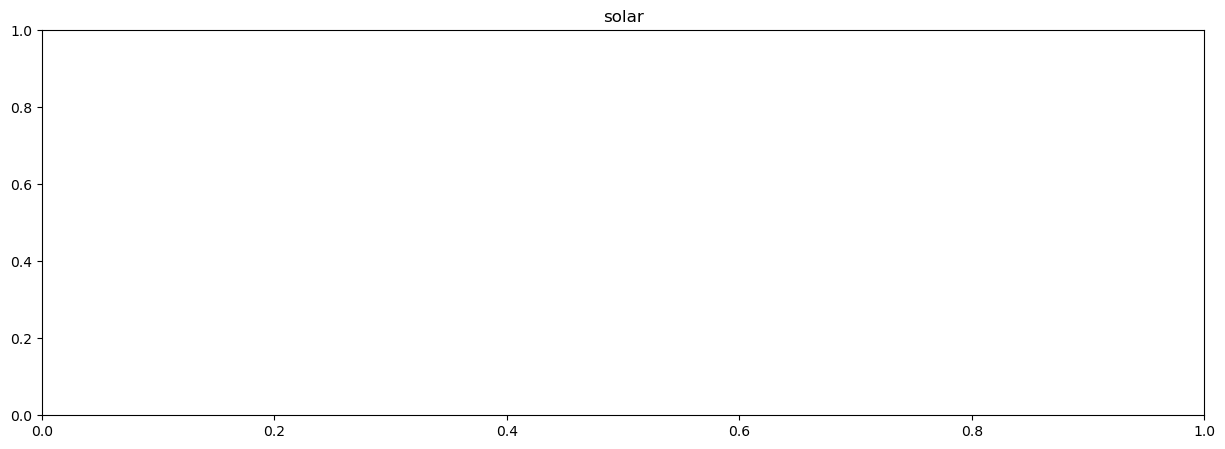

In [7]:
for carrier in ["solar", "solar rooftop", "onwind", "offwind-ac", "offwind-dc"]:

    flex_data = pd.DataFrame(0, index=years, columns=coarse_regions.keys()).stack()
    none_data = pd.DataFrame(0, index=years, columns=coarse_regions.keys()).stack()

    flex_data = pd.DataFrame(0, index=flex_data.index, columns=[carrier])
    none_data = pd.DataFrame(0, index=none_data.index, columns=[carrier])

    for year in years:
        
        flex = pypsa.Network(base / template.format(flex_wc, year))
        none = pypsa.Network(base / template.format(unflex_wc, year))

        def get_carrier(n, carrier):

            # if carrier == "wind" or carrier == "solar":
            #     solar = (g := n.generators).loc[g.carrier.str.contains(carrier)]
            # else:
            solar = (g := n.generators).loc[g.carrier == carrier]

            solar.loc[:, ["bus"]] = solar.bus.str.split(" ").str[:2].str.join(" ")
            solar.loc[solar.bus.str.contains("GB"), ].groupby("bus")["p_nom_opt"].sum()

            result = pd.Series(index=coarse_regions.keys())
            for region, buses in coarse_regions.items():
                result[region] = solar.loc[solar.bus.isin(buses), "p_nom_opt"].sum()
            
            return result
        
        flex_data.loc[idx[year, :], [carrier]] = get_carrier(flex, carrier).values
        none_data.loc[idx[year, :], [carrier]] = get_carrier(none, carrier).values


    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.set_title(carrier)

    for region, c in zip(coarse_regions.keys(), colors):
        ax.plot(years, none_data.loc[idx[:, [region]], carrier].values, label=region, color=c)
        ax.plot(years, flex_data.loc[idx[:, [region]], carrier].values, label=region + " flex", color=c, linestyle="--")

    ax.legend()
    plt.show()



KeyError: 'wind'

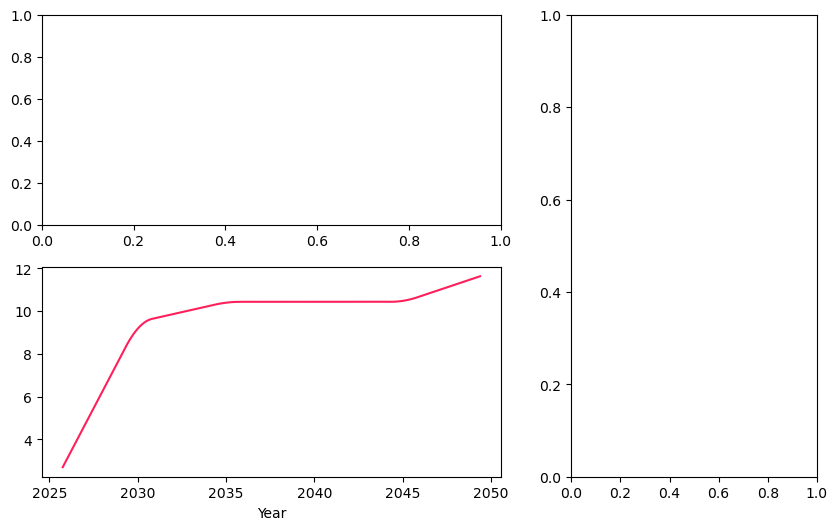

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import LinearLocator

# colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
# colors = ["#7fcebc", "#41b7c5", "#1d92c1", "#225ea9", "#253495"]
colors = ["#FF1F5B", "#009ADE", "#AF58BA", "#FFC61C", "#F28522"]

# Create a figure
fig = plt.figure(figsize=(10, 6))

# Define the grid layout
gs = gridspec.GridSpec(2, 2, width_ratios=[1.87, 1])

# Create subplots
ax1 = plt.subplot(gs[0, 0]) # First row, first column
ax2 = plt.subplot(gs[1, 0]) # Second row, first column
ax3 = plt.subplot(gs[:, 1]) # Span all rows, second column

# Plot data in each subplot
# Subplot 1 (Top left)

# Subplot 2 (Bottom left)
# ax2.set_title('Subplot 2')
ax2.set_xlabel('Year')

def get_smooth_xy(x, y):
    new_x = np.linspace(min(x), max(x), 200)
    new_y = np.interp(new_x, x, y)

    series = pd.Series(new_y, index=new_x).rolling(12, center=True).mean()
    return series.index, series.values


for region, color in zip(coarse_regions.keys(), colors):

    for ax, data, carrier, ls in zip(
        [ax2, ax1, ax2, ax1],
        [none_data, none_data, flex_data, flex_data],
        ["solar", "wind", "solar", "wind"],
        ["-", "-", "--", "--"],
        ):
        x, y = get_smooth_xy(years, data.loc[idx[:, [region]], carrier].values)
        ax.plot(x, y*1e-3, color=color, linestyle=ls)


legend, handles = ax1.get_legend_handles_labels()
labels = ["Inflexible System", "Flexible System"]
handles = [Line2D([0], [0], color="black", linestyle="-"), Line2D([0], [0], color="black", linestyle="--")]
ax1.legend(
    handles,
    labels,
    loc="upper left",
    # bbox_to_anchor=(0.8, -0.0),
    ncol=1,
    )

handles, labels = list(), list()
for color, (region, buses) in zip(colors, coarse_regions.items()):
    # gpd.GeoSeries(geometry=[regions.loc[buses, "geometry"].unary_union]).plot(ax=ax3, color=color, edgecolor="black")
    temp = regions.loc[buses, "geometry"].unary_union
    gpd.GeoSeries([temp]).set_crs("EPSG:4326").plot(
        ax=ax3,
        color=color,
        edgecolor="black",
        label=region,
        )
    # handles.append(Patch(color=color))
    handles.append(Line2D([0], [0], marker='o', markerfacecolor=color, color='w', markersize=15))
    labels.append(region)

# ax3.legend(handles, labels, bbox_to_anchor=(0, -0.1), ncol=5)
fig.legend(handles, labels, bbox_to_anchor=(0.935, 0.02), ncol=5, frameon=False)

# ax3.set_title('Subplot 3')
ax3.set_ylim([49.7, 59.])
ax3.set_xlim([-8, 2])
ax3.set_xticks([])
ax3.set_yticks([])

for ax in [ax1, ax2]:
    ax.set_xlim(2025, 2050)
    ax.xaxis.set_major_locator(LinearLocator(6))
    ax.set_xticklabels([2025, 2030, 2035, 2040, 2045, 2050])
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax1.set_ylabel("Wind Capacity (GW)")
ax2.set_ylabel("Solar Capacity (GW)")

ax1.set_xticklabels([])


print('PLOT CORRELATION OF RENEWABLES VS FLEXIBILITY')


plt.tight_layout()

plt.savefig("windsolarexpansion.pdf", bbox_inches="tight")
plt.show()

In [13]:
"""
coarse_regions = {
    "Scotland": ["GB0 Z1_3", "GB0 Z1_4", "GB0 Z2", "GB0 Z3", "GB0 Z5"],
    "Cornwall": ["GB0 Z17"],
    "Wales, West-England": ["GB0 Z13", "GB0 Z9"],
    "South-East England": ["GB0 Z16", "GB0 Z15", "GB0 Z14", "GB0 Z12"],
    "North-East England": ["GB0 Z11", "GB0 Z10", "GB0 Z8", "GB0 Z7", "GB0 Z6"],
}
"""
coarse_regions = {
    region: [region] for region in [
        "GB0 Z11", "GB0 Z10", "GB0 Z8", "GB0 Z7", "GB0 Z6",
        "GB0 Z16", "GB0 Z15", "GB0 Z14", "GB0 Z12", "GB0 Z13", "GB0 Z9", "GB0 Z17",
        "GB0 Z1_3", "GB0 Z1_4", "GB0 Z2", "GB0 Z3", "GB0 Z5"
    ]}

reverse_coarse_regions = {v: k for k, vs in coarse_regions.items() for v in vs}

In [10]:
import pandas as pd
from pathlib import Path
import pypsa

def get_intermittent_caps(n):
    intermittents = ["solar rooftop", "onwind", "offwind-ac", "offwind-dc", "solar"]

    b = n.loads.bus.str.split(" ").str[:2].str.join(" ")
    b = b.loc[b.str.contains("GB")].unique()

    results = pd.DataFrame(index=b, columns=intermittents)

    for carrier in intermittents:    
        
        g = n.generators.loc[(n.generators.carrier == carrier) & (n.generators.bus.str.contains("GB"))]
        g.index = g.bus.str.split(" ").str[:2].str.join(" ")
        results.loc[g.index, carrier] = g.p_nom_opt

    return results.fillna(0)

base = Path.cwd().parent / "results" / "pypsa-fes" / "networks"
nn = "elec_s_ec_lhnd__{}_LW_{}.nc"

# get_intermittent_caps(pypsa.Network(base / nn.format("int-tank-ss-v2g", 2040)))



In [27]:
regions = gpd.read_file(Path.cwd().parent / "resources" / "pypsa-fes" / "regions_onshore_elec_s_eso.geojson")
regions.index = regions["name"]
regions = regions.loc[regions.index.str.contains("GB")]
regions = regions.loc[list(reverse_coarse_regions)]
regions.loc[:,["coarse_regions"]] = regions["name"].apply(lambda x: reverse_coarse_regions[x])
regions = regions.groupby("coarse_regions").agg({"geometry": lambda x: x.unary_union})
regions = gpd.GeoDataFrame(regions, geometry="geometry").set_crs("EPSG:4326").to_crs(epsg=4299)
# 4188, 4299

In [150]:
ms = stats.copy()

dfindex = ms.columns.to_frame()
"""
level = ms.columns.get_level_values(2)
replaces = {entry: "" for entry in level if "Unnamed" in entry}
level = [replaces.get(entry, entry) for entry in level]
# ms.columns = ms.columns.set_levels(level, level=2)
ms.columns.set_level_values(level, level=2)

"""

dfindex.loc[dfindex.flexopts.str.contains("Unnamed"), "flexopts"] = ""
ms.columns = pd.MultiIndex.from_frame(dfindex)

ms

ll                                            hnd                     \
opt                            Unnamed: 2_level_1 Unnamed: 3_level_1   
flexopts                          int-tank-ss-v2g    int-tank-ss-v2g   
fes                                            LW                 LW   
year                                         2025               2030   
GB0 Z10 OCGT_energy                      0.000000           0.000000   
        CCGT_energy                      0.000000           0.000000   
        allam_energy                     8.277242           7.481215   
        nuclear_energy                   0.000000           0.000000   
        modular nuclear_energy           0.000000           0.000000   
...                                           ...                ...   
GB0 Z9  OCGT_p_nom                      80.668730          47.674690   
        CCGT_p_nom                    4802.094284        2838.006183   
        allam_p_nom                      0.002249           0.002475   
        nuclear_p_nom                    0.000000           0.000000   
        biomass_p_nom                  412.400000         412.400000   

ll                                                                    \
opt                            Unnamed: 4_level_1 Unnamed: 5_level_1   
flexopts                          int-tank-ss-v2g    int-tank-ss-v2g   
fes                                            LW                 LW   
year                                         2035               2040   
GB0 Z10 OCGT_energy                      0.000000           0.000000   
        CCGT_energy                      0.000000           0.000000   
        allam_energy                   978.762745      407689.235872   
        nuclear_energy                   0.000000           0.000000   
        modular nuclear_energy           0.000000           0.000000   
...                                           ...                ...   
GB0 Z9  OCGT_p_nom                      15.761037           0.000000   
        CCGT_p_nom                     938.232034           0.000000   
        allam_p_nom                      0.086988          57.218632   
        nuclear_p_nom                    0.000000           0.000000   
        biomass_p_nom                  412.400000         412.400000   

ll                                                                    \
opt                            Unnamed: 6_level_1 Unnamed: 7_level_1   
flexopts                          int-tank-ss-v2g    int-tank-ss-v2g   
fes                                            LW                 LW   
year                                         2045               2050   
GB0 Z10 OCGT_energy                      0.000000           0.000000   
        CCGT_energy                      0.000000           0.000000   
        allam_energy                254862.816690       65975.703203   
        nuclear_energy                   0.000000           0.000000   
        modular nuclear_energy           0.000000           0.000000   
...                                           ...                ...   
GB0 Z9  OCGT_p_nom                       0.000000           0.000000   
        CCGT_p_nom                       0.000000           0.000000   
        allam_p_nom                    497.057168         825.104486   
        nuclear_p_nom                    0.000000           0.000000   
        biomass_p_nom                  412.400000         412.400000   

ll                                                                    \
opt                            Unnamed: 8_level_1 Unnamed: 9_level_1   
flexopts                           go-tank-ss-v2g     go-tank-ss-v2g   
fes                                            LW                 LW   
year                                         2025               2030   
GB0 Z10 OCGT_energy                      0.000000           0.000000   
        CCGT_energy                      0.000000           0.000000   
        allam_energy                 

In [155]:
year = 2035
idx = pd.IndexSlice

vis_threshold = 0.3

stats = pd.read_csv(
    Path.cwd().parent / "results" / "pypsa-fes" / "csvs" / "flex_statistics.csv",
    header=[0,1,2,3,4],
    index_col=[0,1],
    )

dfindex = stats.columns.to_frame()
dfindex.loc[dfindex.flexopts.str.contains("Unnamed"), "flexopts"] = ""
stats.columns = pd.MultiIndex.from_frame(dfindex)

years = [2025, 2030, 2035, 2040, 2045, 2050]

flex_col = stats.loc[:, idx[:, :, "int-tank-ss-v2g", :, str(year)]].iloc[:,0]
other_col = stats.loc[:, idx[:, :, "", :, str(year)]].iloc[:,0]

flex_col = pd.concat([
    flex_col,
    get_intermittent_caps(pypsa.Network(base / nn.format("int-tank-ss-v2g", year))).stack()
    ], axis=0)
other_col = pd.concat([
    other_col,
    get_intermittent_caps(pypsa.Network(base / nn.format("", year))).stack()
    ], axis=0)


flex_series = []
other_series = []

def get_summed(col, buses, region):

    col = col.loc[idx[buses, :]].groupby(level=1).sum()
    col.index = pd.MultiIndex.from_product(([region], col.index.tolist()))

    return col

for region, buses in coarse_regions.items():

    flex_series.append(get_summed(flex_col, buses, region))
    other_series.append(get_summed(other_col, buses, region))

flex_col = pd.concat(flex_series)
other_col = pd.concat(other_series)

diff = flex_col - other_col

drops = [
    "biogas upgrading",
    "dac_atm",
    "dac_co2",
    "transmission_caplength",
    "transmission_s_nom",
    "distribution_p_nom",
    "abated combustion",
    "OCGT",
    "CCGT",
    ] + [entry for entry in diff.index.get_level_values(1).unique() if "energy" in entry]


diff = diff.drop(drops, level=1).mul(1e-3)

# pos = diff.loc[diff > 0]
# neg = diff.loc[diff < 0]

d = diff.abs().groupby(level=1).sum()
d = d.loc[d > vis_threshold]

diff = diff.loc[:, d.index]
pos = diff.loc[diff > 0]
neg = diff.loc[diff < 0]

INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [156]:
import yaml

with open(Path.cwd().parent / "config" / "config.yaml") as f:
    tech_colors = yaml.safe_load(f)["plotting"]["tech_colors"]
tech_colors["allam_p_nom"] = tech_colors["allam"]
tech_colors["CCGT_p_nom"] = tech_colors["CCGT"]
tech_colors["OCGT_p_nom"] = tech_colors["OCGT"]
tech_colors["biomass_p_nom"] = tech_colors["biomass"]
tech_colors["nuclear_p_nom"] = tech_colors["nuclear"]

C:\Users\lukas\AppData\Local\Temp\ipykernel_24876\808706481.py:176: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels([f"+{int(vmax)}", "0", f"-{int(vmax)}"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_24876\808706481.py:199: UserWarning: FixedFormatter should only be used together with FixedLocator
  bax.set_yticklabels([f'-{bar_gauge_value} GW', f'+{bar_gauge_value} GW'])
C:\Users\lukas\AppData\Local\Temp\ipykernel_24876\808706481.py:222: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


GB0 Z13     1.538274e-09
GB0 Z14     9.674477e-07
GB0 Z15     5.167748e+00
GB0 Z16     1.978868e+01
GB0 Z17     2.775343e-06
GB0 Z1_3    1.139924e+00
GB0 Z5      1.286563e-01
GB0 Z6      7.061155e-08
GB0 Z8      3.831742e+00
GB0 Z9      2.074243e-07
dtype: float64


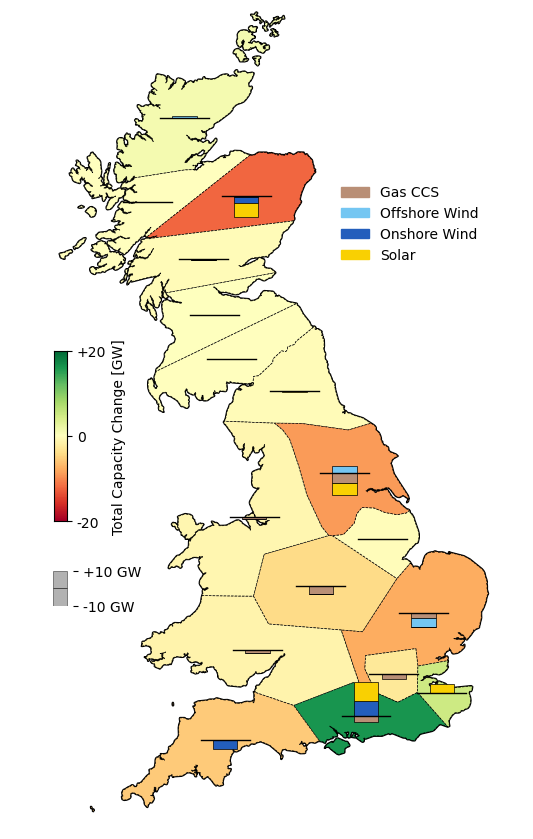

In [157]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
from mpl_toolkits.axes_grid1 import make_axes_locatable

nice_names = {
    "allam_p_nom": "Gas CCS",
    "onwind": "Onshore Wind",
    "offwind-ac": "Offshore Wind",
    "offwind-dc": "Offshore Wind",
    "solar": "Solar",
    "solar rooftop": "Rooftop Solar",
}

fig, ax = plt.subplots(1, 1, figsize=(5.5, 8.5))
# regions.plot(ax=ax, color="white", edgecolor="black", linewidth=1.)
# regions["geometry"].plot(ax=ax, color="white", edgecolor="black", linewidth=1.)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("bottom", size="5%", pad=0.1)

gpd.GeoSeries([regions.unary_union]).plot(ax=ax, color="white", edgecolor="black", linewidth=1.5)

cmap = "RdYlGn"

# vmax = max(pos.groupby(level=0).sum().max(), neg.abs().groupby(level=0).sum().max())
vmax = 20

regions.loc[:, ["total"]] = diff.groupby(level=0).sum()
m = regions.plot(
    ax=ax,
    column="total",
    edgecolor="black",
    linewidth=0.5,
    linestyle="--",
    cmap=cmap,
    vmax=vmax,
    vmin=-vmax,
    )

centroids = {
    "Wales, West-England": (-3.5, 52.4),
    "North-East England": (-1.3, 54),
    "South-East England": (0.5, 50.5),
}

target_radius = 0.1
avg_p = diff.abs().sum() / len(regions) / 2
max_p = max(neg.abs().groupby(level=0).sum().max(), pos.abs().groupby(level=0).sum().max())

def half_pie_to_map(data, startangle, ax, centroid):
    total = data.abs().sum()

    radius = target_radius * (total / avg_p)
    colors = [tech_colors[tech] for tech in data.index]

    ax.pie(
        data.abs().values / 2 / total,
        startangle=startangle,
        normalize=False,
        colors=colors,
        radius=radius,
        center=centroid,
        # labels=data.index,
        **pie_kwargs,
        )

bar_kwargs = {
    "width": 0.5,
    "edgecolor": "black",
    "linewidth": 0.5,
}

bar_gauge_height = 0.2
bar_gauge_value = 10

def bar_to_map(data, centroid, ax):
    
    x = centroid[0]
    y = centroid[1]

    normalizer = bar_gauge_height / bar_gauge_value

    for i, val in enumerate(data.values):
        ax.bar(
            x,
            val * normalizer,
            bottom=data.values[:i].sum() * normalizer + y,
            color=tech_colors[data.index[i]],
            **bar_kwargs,
            )

pie_kwargs = {
    # "wedgeprops": {
    #     "edgecolor": "w",
    # },
    "frame": True,
}


for region, row in regions.iterrows():

    centroid = centroids.get(region, row.geometry.centroid.coords[0])

    try:
        p = pos.loc[idx[region, :]]
        # half_pie_to_map(p, 0, ax, centroid)
        bar_to_map(p, centroid, ax)
    except KeyError:
        pass

    try:
        n = neg.loc[idx[region, :]]
        # half_pie_to_map(n, 180, ax, centroid)
        bar_to_map(n, centroid, ax)
    except KeyError:
        pass

    ax.plot(
        [centroid[0] - bar_kwargs["width"], centroid[0] + bar_kwargs["width"]],
        [centroid[1], centroid[1]],
        color="black",
        linewidth=1.,
        )
    # radius = target_radius * (np.array([p.sum(), n.abs().sum()]) / avg_p).max()

ax.set_xlim(-8, 2.5)
ax.set_ylim(49, 60)

techs = diff.loc[diff.abs() > 0].index.get_level_values(1).unique().tolist()
handles = [Patch(color=tech_colors[tech]) for tech in techs]
techs = [nice_names.get(tech, tech) for tech in techs]

# techs = techs + ["", ""]
# handles = handles + [Patch(color="white"), Patch(color="white")]

"""
techs = techs + [f"{int(max_p/3)} GW", "", f"{int(max_p/3*2)} GW"]
handles = handles + \
    [Line2D([], [], color="white", markerfacecolor="grey", marker=MarkerStyle("o", fillstyle="bottom"), markersize=max_p/3*2)] + \
    [Patch(color="white")] + \
    [Line2D([], [], color="white", markerfacecolor="grey", marker=MarkerStyle("o", fillstyle="bottom"), markersize=max_p/3*2*2)]
"""

# techs += ["10 GW"]
# handles += []
ax.set_ylim(49.7, 59.4)
ax_ydistance = ax.get_ylim()[1] - ax.get_ylim()[0]
ax_xdistance = ax.get_xlim()[1] - ax.get_xlim()[0]

bax_height = 0.2
w = bar_kwargs["width"]

# bax = fig.add_axes([0.7, 0.7, 0.1, bax_height])
# bax = fig.add_axes([0.9, 0.9, 0.1, 2*bax_height/ax_ydistance])

bax_x = 0.1
bax_y = 0.28
offset = 0.1
offset_x = 0.013

bax = fig.add_axes([bax_x, bax_y, w/ax_xdistance, 2*bax_height/ax_ydistance])
cax = fig.add_axes([bax_x + offset_x, bax_y + offset, w/ax_xdistance/2, 0.2])

to_cm = lambda c: LinearSegmentedColormap.from_list("Custom", ["white", c], N=100)

cax.set_xticklabels([])
cax.set_xticks([])

y = np.atleast_2d(np.linspace(0, 1, 100)).T
y = np.hstack((y, y))

cax.imshow(y, aspect='auto', cmap=cmap+"_r")
cax.yaxis.set_major_locator(LinearLocator(3))
cax.set_yticklabels([f"+{int(vmax)}", "0", f"-{int(vmax)}"])
cax.set_ylabel("Total Capacity Change [GW]")
cax.yaxis.set_label_position("right")

# bax.set_xlim(-1, 1)
bax.set_xlim(-w, w)
bax.set_ylim(-1, 1)

bax_ydistance = bax.get_ylim()[1] - bax.get_ylim()[0]

# bax_height = bar_gauge_height / ax_ydistance * bax_ydistance / bax_height
# bax_height = bar_gauge_value

# bax.bar(0, bax_height, color="grey", alpha=0.6, **bar_kwargs)
# bax.bar(0, -bax_height, color="grey", alpha=0.6, **bar_kwargs)
bax.bar(0, 1, color="grey", alpha=0.6, **bar_kwargs)
bax.bar(0, -1, color="grey", alpha=0.6, **bar_kwargs)
bax.yaxis.tick_right()
cax.yaxis.tick_right()

from matplotlib.ticker import LinearLocator
bax.yaxis.set_major_locator(LinearLocator(2))

bax.set_yticklabels([f'-{bar_gauge_value} GW', f'+{bar_gauge_value} GW'])
bax.set_xticks([])

# nospine = lambda ax, loc: ax.spines[loc].set_visible(False)
# list(map(nospine, [bax], ['top', 'bottom', 'left', 'right']))

bax.spines['left'].set_visible(False)
bax.spines['right'].set_visible(False)
bax.spines['top'].set_visible(False)
bax.spines['bottom'].set_visible(False)

# ax.legend(labels=techs, handles=handles, bbox_to_anchor=(1.05, 1), loc='center left', frameon=False)
ax.legend(
    labels=techs,
    handles=handles,
    bbox_to_anchor=(0.62, 0.8),
    # loc='upper right',
    frameon=False
    )
ax.axis("off")
print(pos.groupby(level=0).sum())


plt.tight_layout()

plt.savefig("additions_removals.pdf")
plt.show()

In [227]:
pos.groupby(level=0).sum()

GB0 Z10     4.883820e-07
GB0 Z13     1.110447e-08
GB0 Z14     9.674477e-07
GB0 Z15     5.167748e+00
GB0 Z16     1.978868e+01
GB0 Z17     4.730366e-06
GB0 Z1_3    1.139924e+00
GB0 Z1_4    2.102071e-05
GB0 Z2      7.467555e-08
GB0 Z3      1.984297e-07
GB0 Z5      1.286563e-01
GB0 Z6      1.044734e-07
GB0 Z7      1.964624e-08
GB0 Z8      3.831742e+00
GB0 Z9      5.334410e-07
dtype: float64

In [182]:
print(pos.groupby(level=0).sum())
print(neg.groupby(level=0).sum())

Cornwall               4.730366e-06
North-East England     3.831741e+00
Scotland               1.268581e+00
South-East England     2.495643e+01
Wales, West-England    2.702978e-07
dtype: float64
Cornwall               -5.777711
North-East England    -18.406431
Scotland              -13.105827
South-East England    -14.400819
Wales, West-England    -2.930252
dtype: float64


In [108]:
diff.index.get_level_values(1).unique()

Index(['CCGT', 'CCGT_energy', 'CCGT_p_nom', 'OCGT', 'OCGT_energy',
       'OCGT_p_nom', 'abated combustion', 'allam_energy', 'allam_p_nom',
       'biogas upgrading', 'biomass', 'biomass_energy', 'biomass_p_nom',
       'dac_atm', 'dac_co2', 'distribution_p_nom', 'modular nuclear_energy',
       'nuclear_energy', 'nuclear_p_nom', 'offwind-ac_energy',
       'offwind-dc_energy', 'onwind_energy', 'ror_energy',
       'solar-rooftop_energy', 'solar_energy', 'transmission_caplength',
       'transmission_s_nom'],
      dtype='object')

In [83]:
a = pd.Series(2, index=pd.MultiIndex.from_product([["a"], ["c", "d", "e"]]))
# a.index = a.index.levels[0].str.replace(a.index.get_level_values(0), "mybut")

a.index = pd.MultiIndex.from_product([["new"], a.index.get_level_values(1)])

a

new  c    2
     d    2
     e    2
dtype: int64

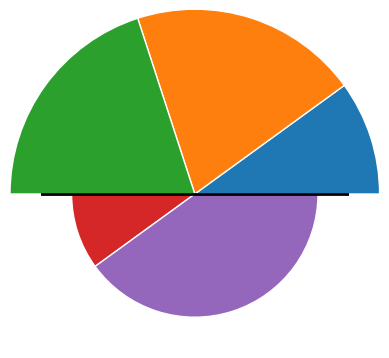

In [36]:
import numpy as np

first = np.array([0.1, 0.2, 0.2])
second = np.array([0.1, 0.4])

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.pie(first, startangle=0, normalize=False, radius=1.5, wedgeprops=dict(edgecolor='w'))
ax.pie(second, startangle=180, normalize=False, radius=1, wedgeprops=dict(edgecolor='w'))

ax.plot([-3, 3], [0, 0], color="black", linewidth=2)

plt.show()

In [71]:
pd.concat((flex_data, none_data), axis=1)

solar          wind         solar  \
2025 Scotland             1925.443107   9936.327387   1925.443107   
     Cornwall             6469.368832   3822.865858   6469.368832   
     Wales               10590.171918   9067.816770  10590.171918   
     South-East England  31464.897567  11181.048710  31464.897567   
     North-East England  12079.999812   8173.341501  12079.999812   
2030 Scotland             8942.103878  14532.932393   8942.103878   
     Cornwall             3152.680163  14620.805452   3152.680163   
     Wales               14846.257338  14560.154229  14846.257338   
     South-East England  28413.747340  20876.852453  28413.747340   
     North-East England  41055.212528  12613.195714  41055.212528   
2035 Scotland            14099.123703  23855.717996  14099.123703   
     Cornwall             4059.269177  18033.786925   4059.269177   
     Wales               19760.243186  18059.352657  19760.243186   
     South-East England  33798.553129  37139.606069  33798.553129   
     North-East England  63437.447416  22242.011928  63437.447416   
2040 Scotland            17532.197262  25236.469049  17532.197262   
     Cornwall             4657.758613  20133.792875   4657.758613   
     Wales               23306.444080  19078.355383  23306.444080   
     South-East England  36725.120294  46095.444390  36725.120294   
     North-East England  80552.066227  23455.135159  80552.066227   
2045 Scotland            19017.777850  25236.504663  19017.777850   
     Cornwall             5378.182983  20876.502939   5378.182983   
     Wales               27575.126071  19078.353527  27575.126071   
     South-East England  45611.227830  48985.107254  45611.227830   
     North-East England  96721.701670  23455.132126  96721.701670   

                                 wind  
2025 Scotland             9936.327387  
     Cornwall             3822.865858  
     Wales                9067.816770  
     South-East England  11181.048710  
     North-East England   8173.341501  
2030 Scotland            14532.932393  
     Cornwall            14620.805452  
     Wales               14560.154229  
     South-East England  20876.852453  
     North-East England  12613.195714  
2035 Scotland            23855.717996  
     Cornwall            18033.786925  
     Wales               18059.352657  
     South-East England  37139.606069  
     North-East England  22242.011928  
2040 Scotland            25236.469049  
     Cornwall            20133.792875  
     Wales               19078.355383  
     South-East England  46095.444390  
     North-East England  23455.135159  
2045 Scotland            25236.504663  
     Cornwall            20876.502939  
     Wales               19078.353527  
     South-East England  48985.107254  
     North-East England  23455.132126